In [42]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm.notebook import tqdm
from pathlib import Path

warnings.filterwarnings("ignore")

## Variáveis de ambiente

In [43]:
MAXIMUM_STUMPS: int = 500
K_FOLDS_COUNT:int = 5
RANDOM_SEED: int = 42

image_folder_path = Path("../images")
image_folder_path.mkdir(parents=True, exist_ok=True)
plots_path = image_folder_path / f"plots_{MAXIMUM_STUMPS}_stumps"
plots_path.mkdir(parents=True, exist_ok=True)

In [44]:
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, header=None)
    
    n_features = df.shape[1] - 1
    df.columns = [f'x{i}' for i in range(n_features)] + ['y']
    
    df['y'] = df['y'] == 'positive'
    
    return df
file_path = "../data/tictactoe/tic-tac-toe.data"
dataset_df = load_and_preprocess_data(file_path)

print(dataset_df.head())

  x0 x1 x2 x3 x4 x5 x6 x7 x8     y
0  x  x  x  x  o  o  x  o  o  True
1  x  x  x  x  o  o  o  x  o  True
2  x  x  x  x  o  o  o  o  x  True
3  x  x  x  x  o  o  o  b  b  True
4  x  x  x  x  o  o  b  o  b  True


# Implementação da classe

In [45]:
class AdaBoost:
    def __init__(self, n_estimators: int = 5):
        self.n_estimators = n_estimators
        self.estimators: List[Tuple[str, any, bool]] = []
        self.estimator_errors = np.zeros(n_estimators)
        self.alphas = np.zeros(n_estimators)
        self.fitted = False

    def fit(self, X: pd.DataFrame, y: pd.Series):
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples
        y_encoded = np.where(y == 1, 1, -1)

        r = range(self.n_estimators)
        #tqdm_r = tqdm(r, desc="Fit progress", leave=False)
        for i in r:
            stump, error = self._find_best_stump(X, y_encoded, weights)
            alpha = 0.5 * np.log((1 - error) / error)

            self.estimators.append(stump)
            self.alphas[i] = alpha
            self.estimator_errors[i] = error

            predictions = self._stump_predict(X, stump)
            weights *= np.exp(-alpha * y_encoded * predictions)
            weights /= np.sum(weights)

        self.fitted = True

    def _find_best_stump(self, X: pd.DataFrame, y: np.ndarray, weights: np.ndarray) -> Tuple[
        Tuple[str, any, bool], float]:
        best_error = float('inf')
        best_stump = None

        for col in X.columns:
            for val in X[col].unique():
                for implication in [True, False]:
                    predictions = self._stump_predict(X, (col, val, implication))
                    error = np.sum(weights * (predictions != y))

                    if error < best_error:
                        best_error = error
                        best_stump = (col, val, implication)

        return best_stump, best_error

    @staticmethod
    def _stump_predict(X: pd.DataFrame, stump: Tuple[str, any, bool]) -> np.ndarray:
        col, val, implication = stump
        condition = X[col] == val if implication else X[col] != val
        return np.where(condition, 1, -1)

    def predict(self, X: pd.DataFrame, n_estimators: int = None) -> np.ndarray:
        assert self.fitted, "Model must be fitted before predicting"

        n_estimators = n_estimators or self.n_estimators
        predictions = np.zeros(X.shape[0])
        for stump, alpha in zip(self.estimators[:n_estimators], self.alphas[:n_estimators]):
            predictions += alpha * self._stump_predict(X, stump)

        return np.where(predictions > 0, 1, 0)


## Validação cruzada

In [46]:
def adaboost_cross_validation(
    X: pd.DataFrame,
    y: pd.Series,
    k_splits: int = K_FOLDS_COUNT,
    max_n_estimators: int = 5,
    random_state: int = RANDOM_SEED
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=random_state)
    
    scores = np.zeros((3, max_n_estimators))
    
    for train_index, test_index in tqdm(kf.split(X), desc="Cross validation step", total=k_splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier = AdaBoost(n_estimators=max_n_estimators)
        classifier.fit(X_train, y_train)
        
        for i in range(1, max_n_estimators + 1):
            predictions = classifier.predict(X_test, n_estimators=i)

            acc = metrics.accuracy_score(y_test, predictions)
            scores[0, i-1] += acc
            scores[1, i-1] += metrics.f1_score(y_test, predictions)
            # error rate
            scores[2, i-1] += 1 - acc  
    
    return scores / k_splits

def get_x_y_from_df(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop('y', axis=1)
    y = df['y']
    return X, y

X, y = get_x_y_from_df(dataset_df)

accuracy_scores, f1_scores, errors = adaboost_cross_validation(
    X=X,
    y=y,
    k_splits=K_FOLDS_COUNT,
    max_n_estimators=MAXIMUM_STUMPS,
    random_state=RANDOM_SEED
)


Cross validation step:   0%|          | 0/5 [00:00<?, ?it/s]

# Gráficos iniciais

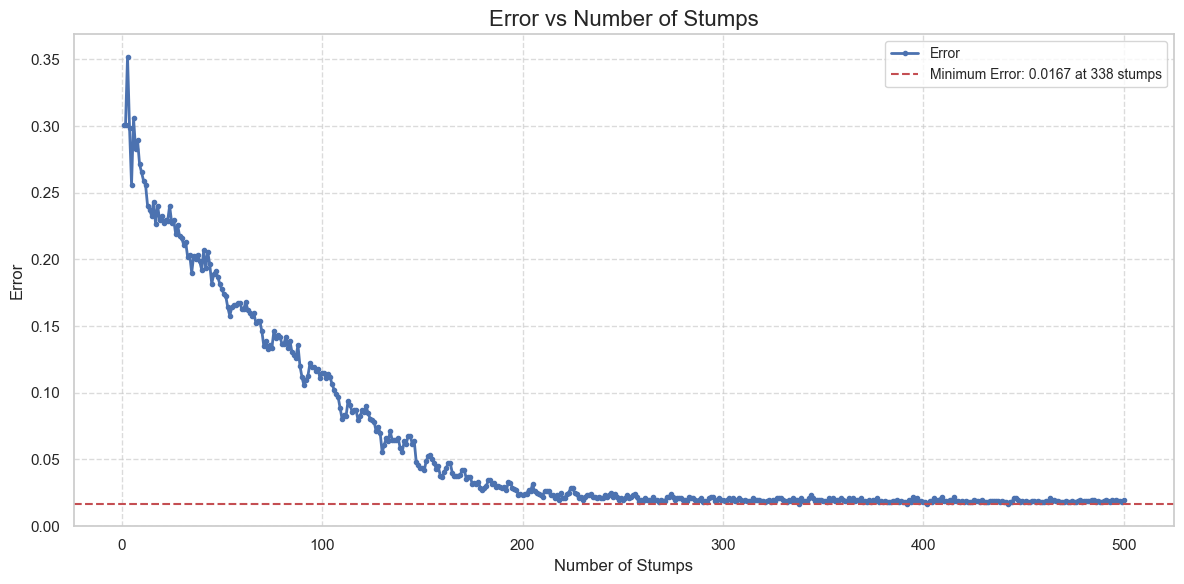

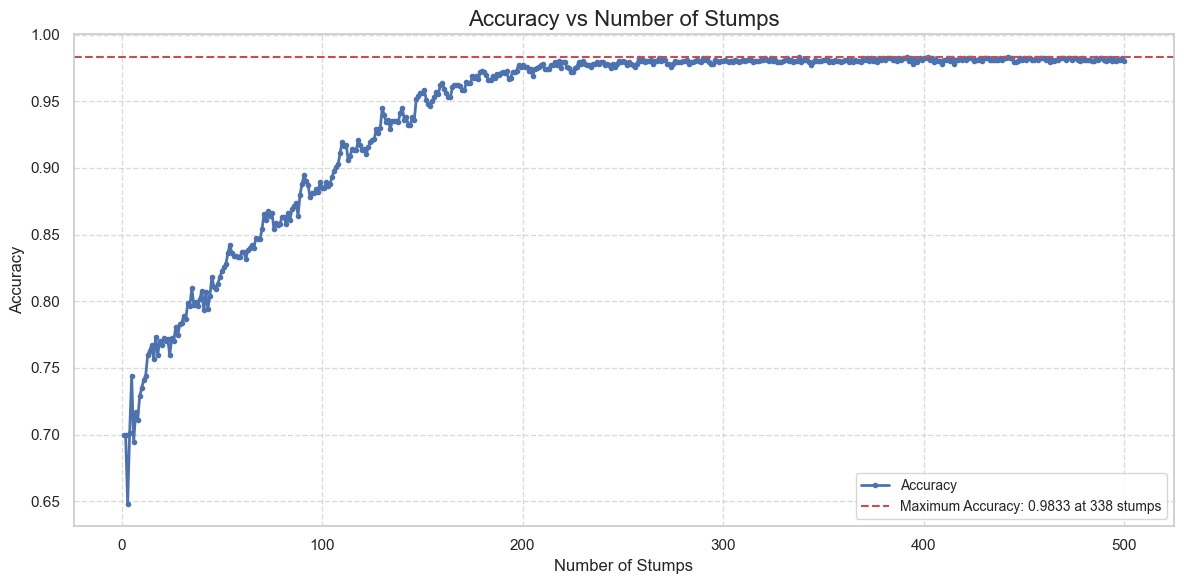

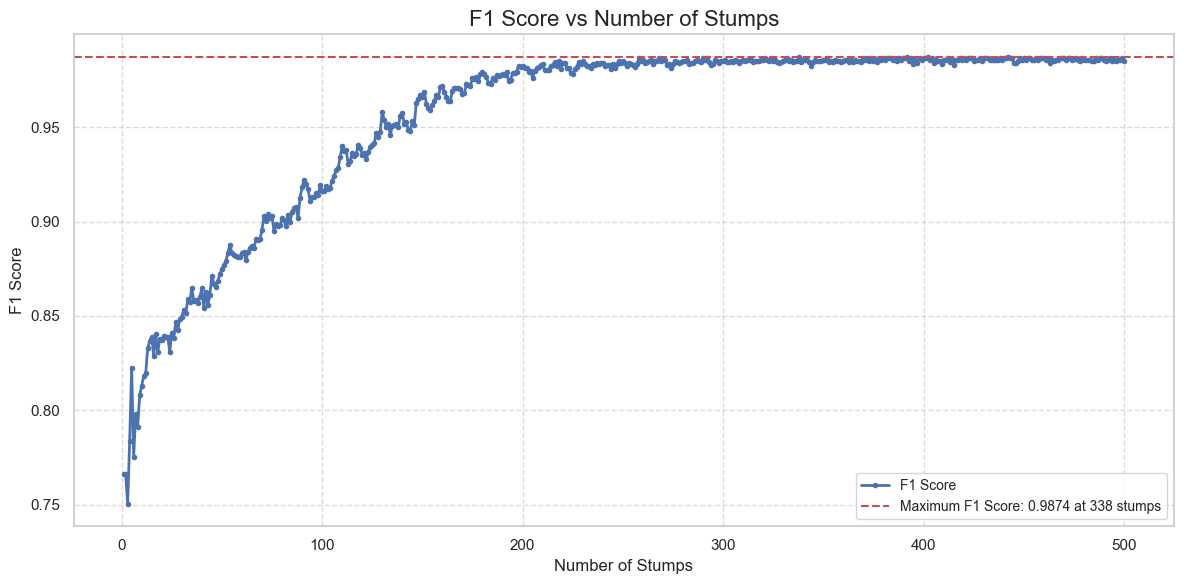

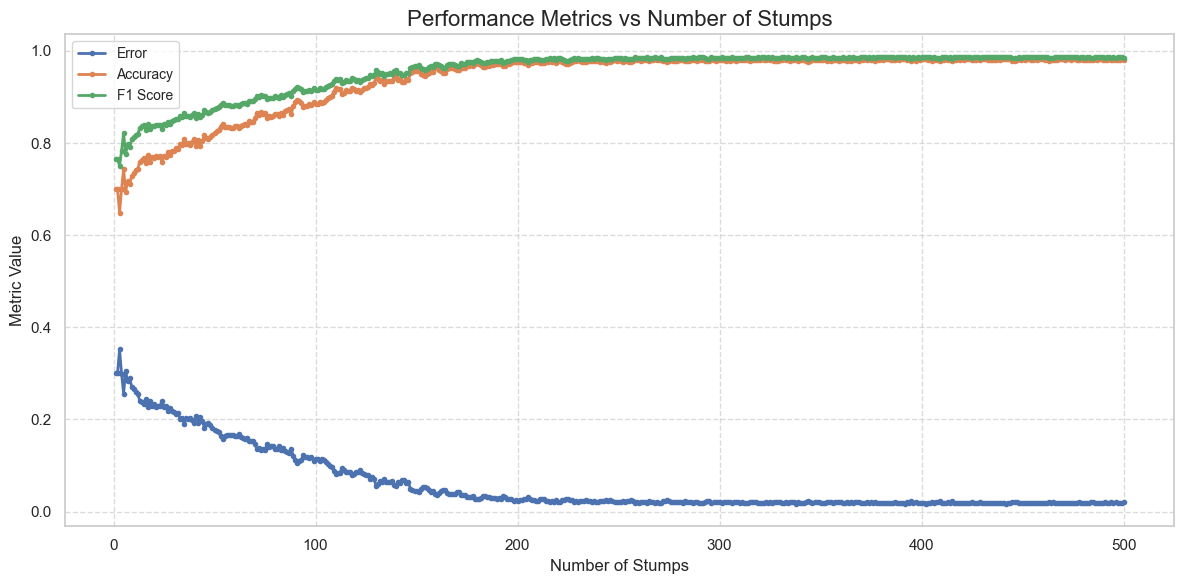

In [47]:
def plot_all_metrics(
    metrics: List[np.ndarray],
    metric_names: List[str],
    save: bool = False,
    save_path: str = None,
) -> None:
    sns.set_style("whitegrid")

    x = np.arange(1, len(metrics[0]) + 1)
    
    for metric, name in zip(metrics, metric_names):
        plt.figure(figsize=(12, 6))
        plt.plot(x, metric, marker='.', linewidth=2, markersize=6, label=name)
        
        if name == "Error":
            best_value = np.min(metric)
            best_label = "Minimum"
        else:
            best_value = np.max(metric)
            best_label = "Maximum"
        best_position = np.where(metric == best_value)[0][0] + 1
        
        plt.axhline(y=best_value, color='r', linestyle='--', 
                    label=f'{best_label} {name}: {best_value:.4f} at {best_position} stumps')
        
        plt.title(f"{name} vs Number of Stumps", fontsize=16)
        plt.xlabel("Number of Stumps", fontsize=12)
        plt.ylabel(name, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
    
        if save:
            save_path = plots_path / f"{name}_{MAXIMUM_STUMPS}.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    plt.figure(figsize=(12, 6))
    for metric, name in zip(metrics, metric_names):
        plt.plot(x, metric, marker='.', linewidth=2, markersize=6, label=name)

    plt.title("Performance Metrics vs Number of Stumps", fontsize=16)
    plt.xlabel("Number of Stumps", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save:
        if save_path is None:
            save_path =  plots_path / f"performance_metrics_{MAXIMUM_STUMPS}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

plot_all_metrics(
    metrics=[errors, accuracy_scores, f1_scores],
    metric_names=["Error", "Accuracy", "F1 Score"],
    save=True,
    save_path= plots_path /"adaboost_performance_{MAXIMUM_STUMPS}.png"
)

## Gráficos de variação e janelas móveis

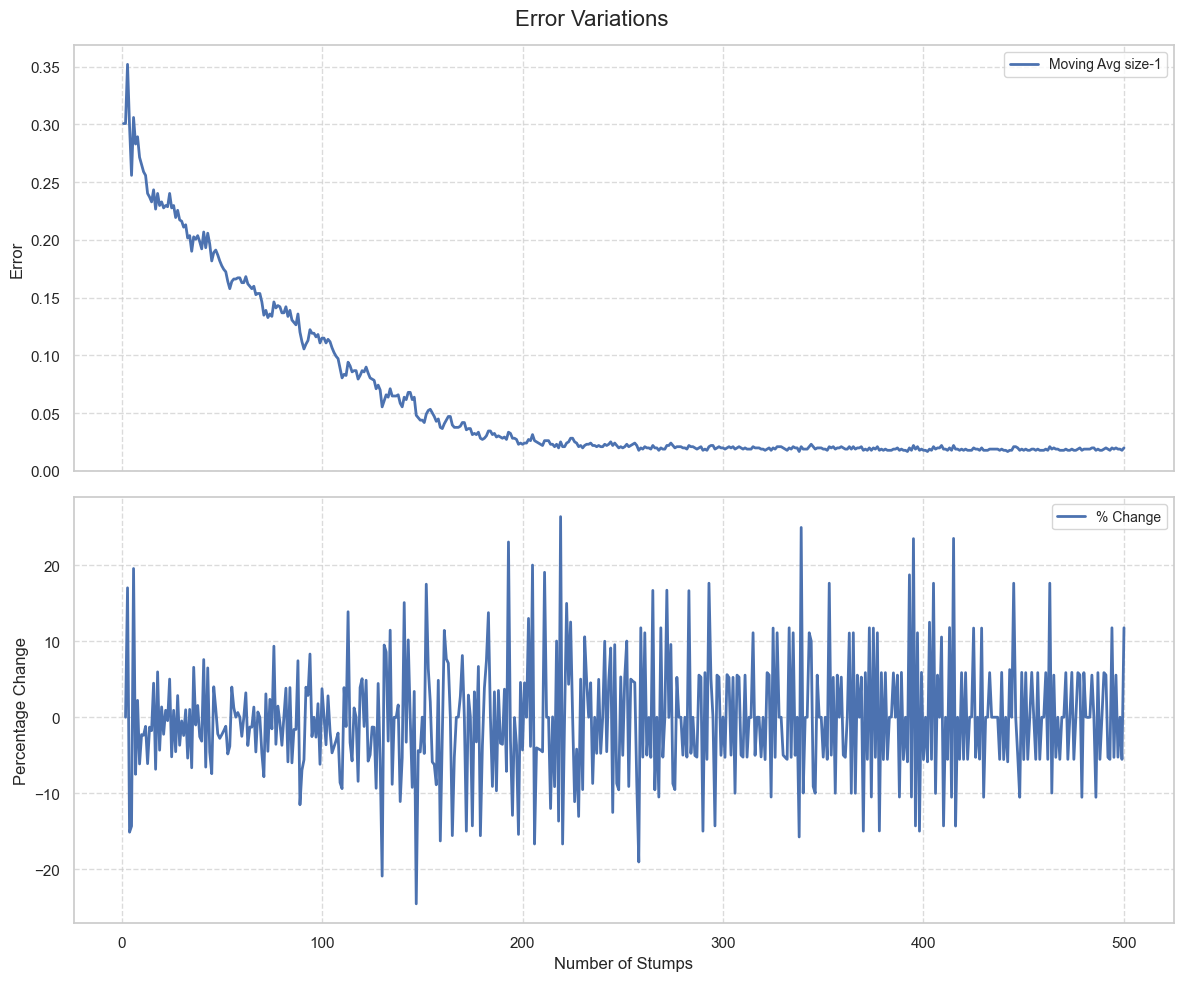

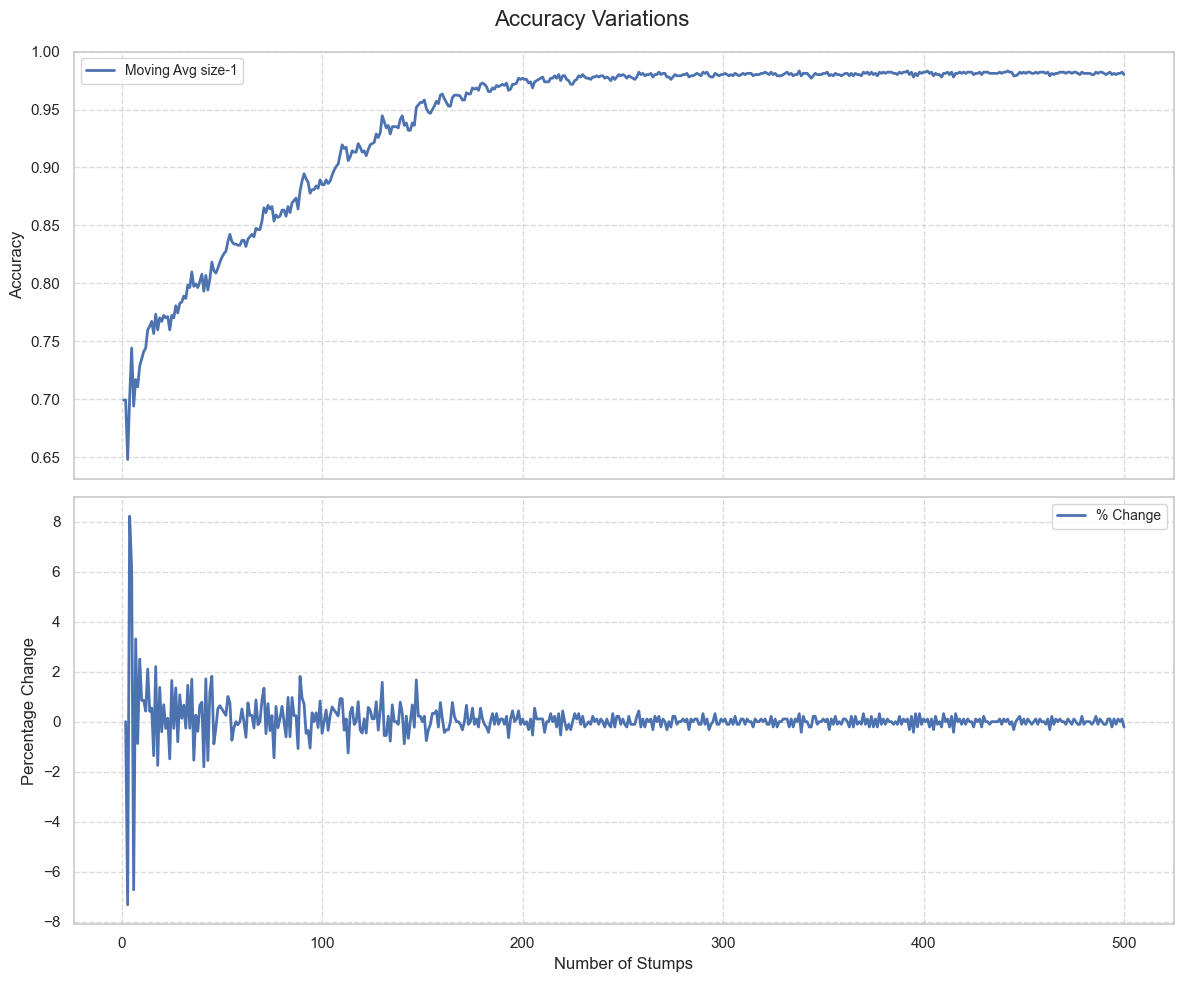

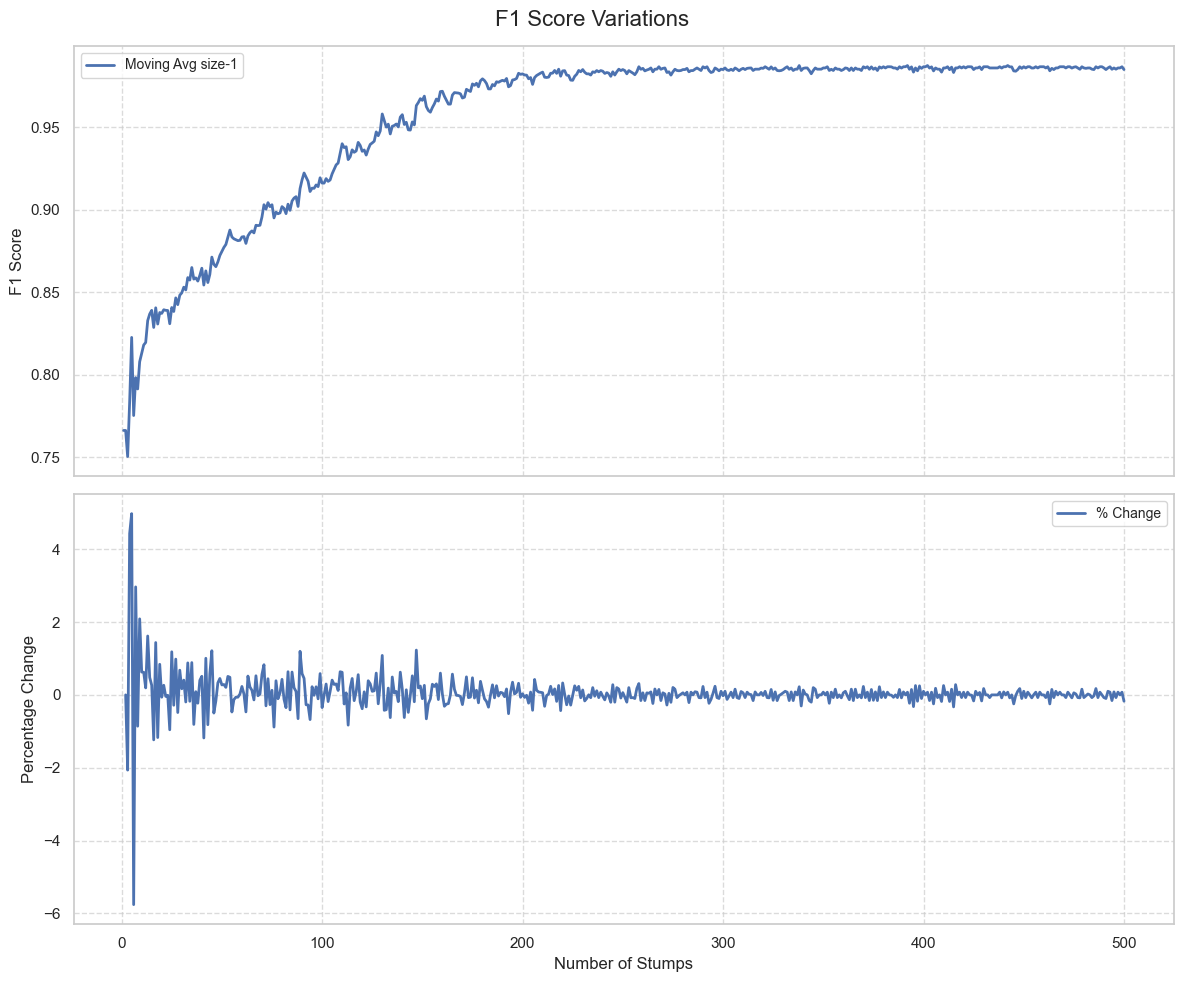

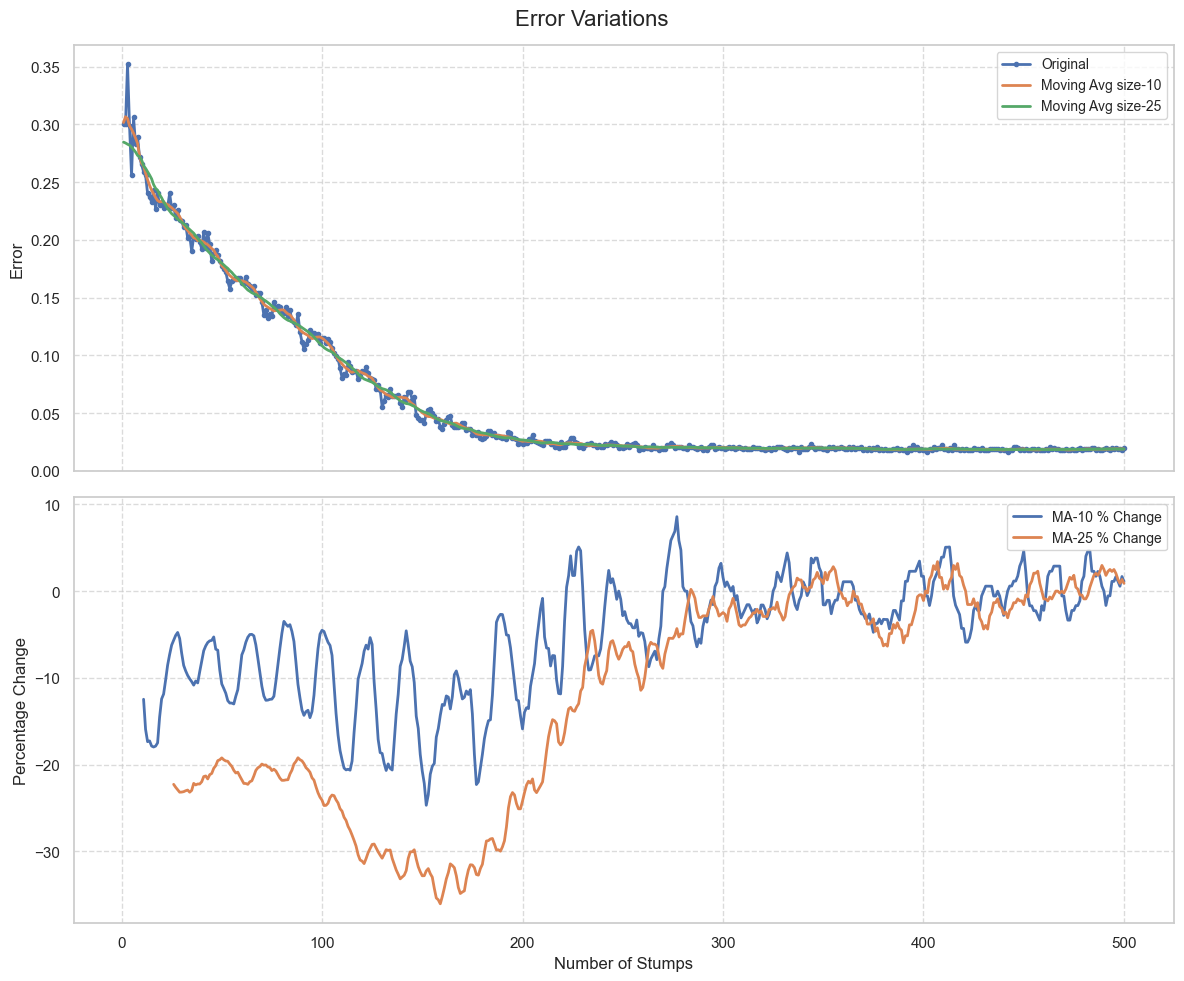

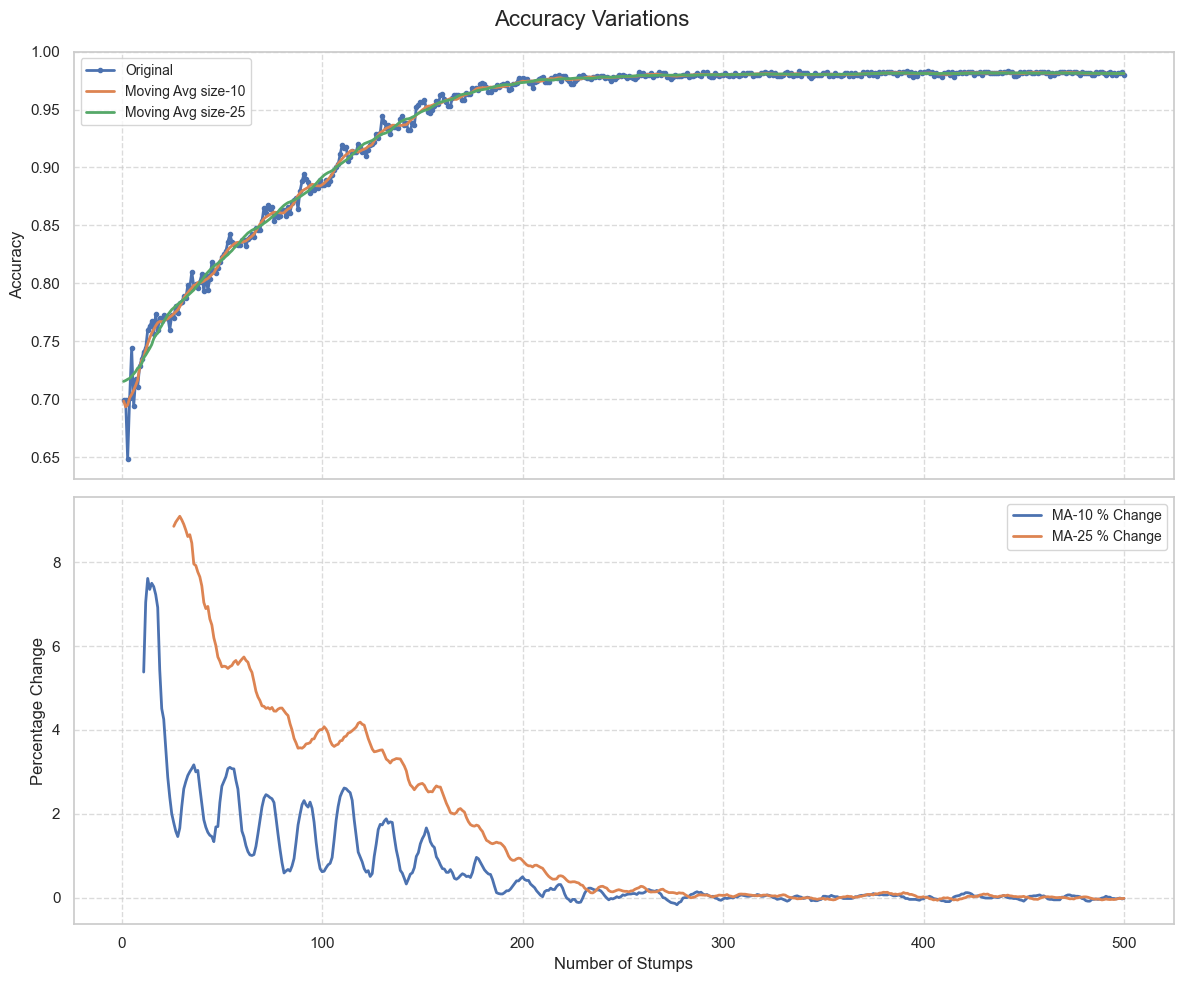

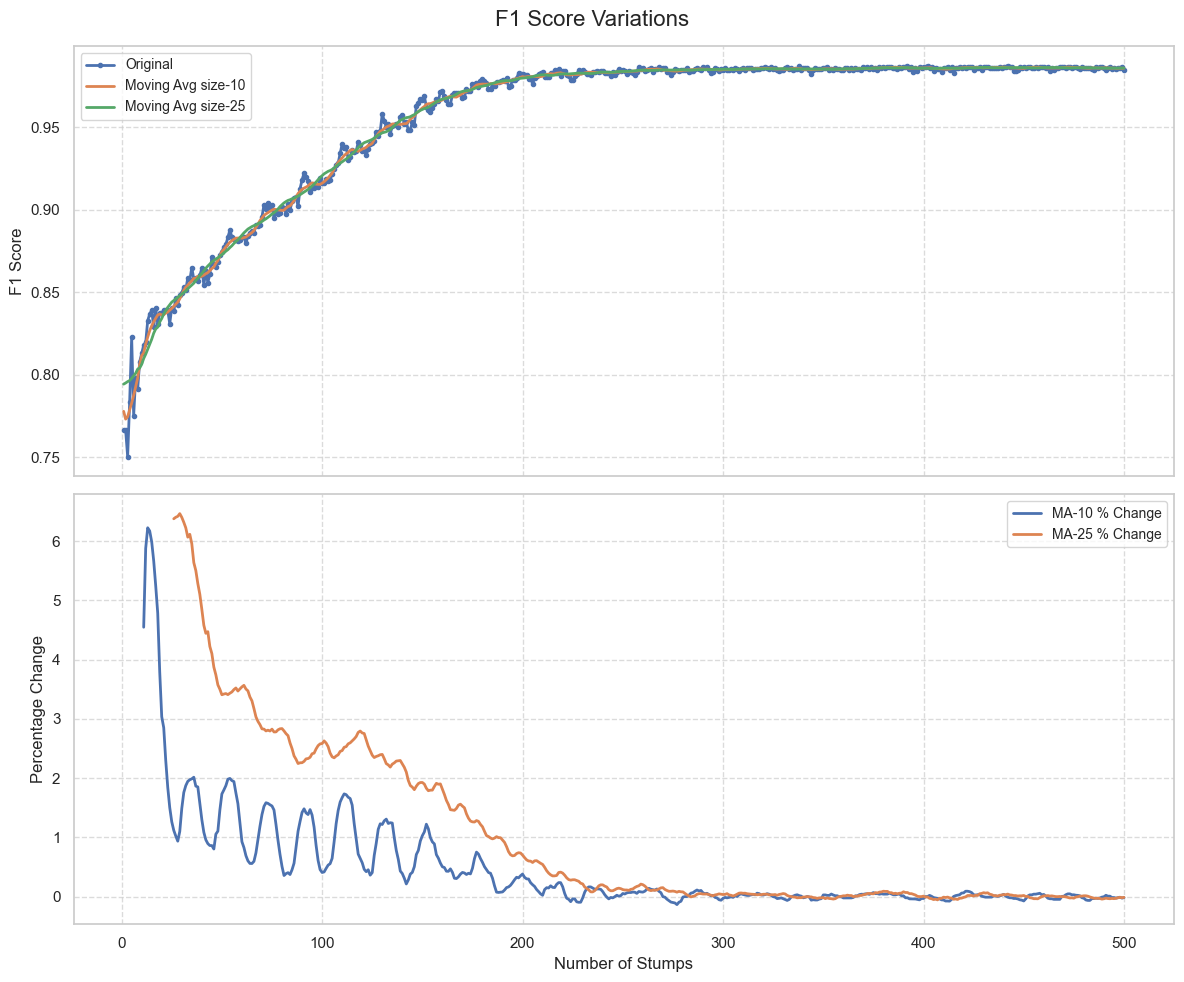

In [48]:
from scipy.ndimage import uniform_filter1d

def plot_metric_variations(
    metrics: List[np.ndarray],
    metric_names: List[str],
    window_sizes: List[int] = [1, 3, 5],
    save: bool = False,
    save_path: str = None
) -> None:
    sns.set_style("whitegrid")
    
    for metric, name in zip(metrics, metric_names):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f"{name} Variations", fontsize=16)
        
        x = np.arange(1, len(metric) + 1)
        
        if not (len(window_sizes) == 1 and window_sizes[0] == 1):
            ax1.plot(x, metric, marker='.', linewidth=2, markersize=6, label='Original')
        
        for window in window_sizes:
            ma = uniform_filter1d(metric, size=window)
            ax1.plot(x, ma, linewidth=2, label=f'Moving Avg size-{window}')
        
        ax1.set_ylabel(name, fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        for window in window_sizes:
            ma = uniform_filter1d(metric, size=window)
            if window == 1:
                variation = np.diff(ma) / ma[:-1] * 100
                ax2.plot(x[1:], variation, linewidth=2, label=f'% Change')
            else:
                variation = (ma[window:] - ma[:-window]) / ma[:-window] * 100
                ax2.plot(x[window:], variation, linewidth=2, label=f'MA-{window} % Change')
        
        ax2.set_xlabel("Number of Stumps", fontsize=12)
        ax2.set_ylabel("Percentage Change", fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        
        if save:
            concatenated_ma = '-'.join(map(str, window_sizes))
            save_path =  plots_path / f"{name}_variations_ma{concatenated_ma}_{MAXIMUM_STUMPS}.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

plot_metric_variations(
    metrics=[errors, accuracy_scores, f1_scores],
    metric_names=["Error", "Accuracy", "F1 Score"],
    window_sizes=[1],
    save=True
)

plot_metric_variations(
    metrics=[errors, accuracy_scores, f1_scores],
    metric_names=["Error", "Accuracy", "F1 Score"],
    window_sizes=[10, 25],
    save=True
)

# Gráfico dos estimadores

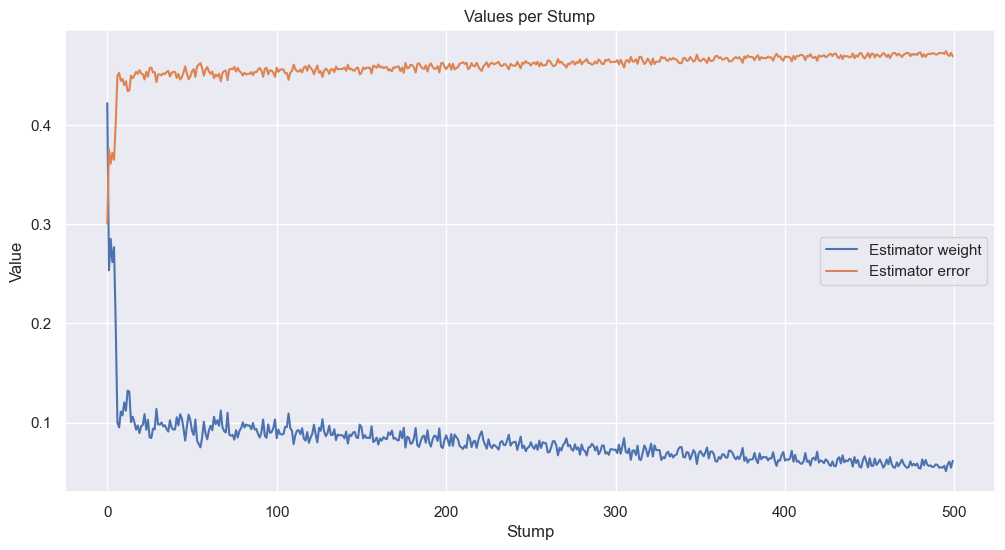

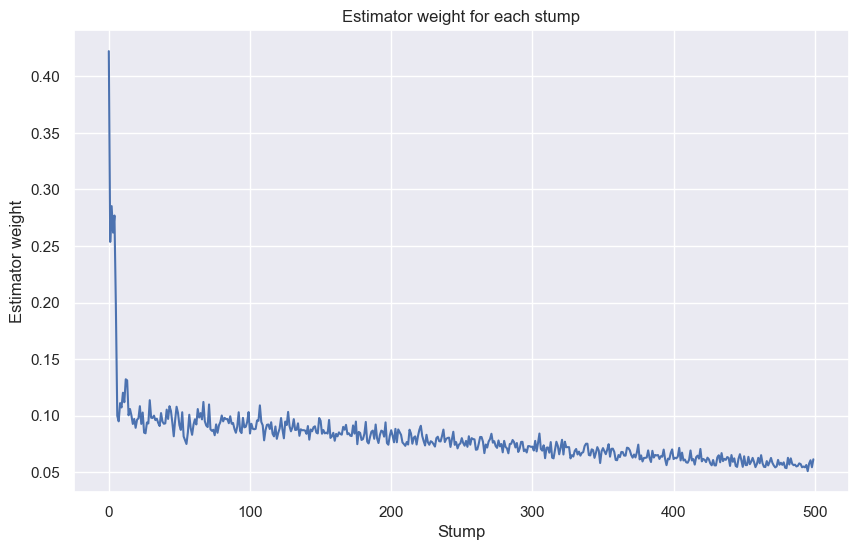

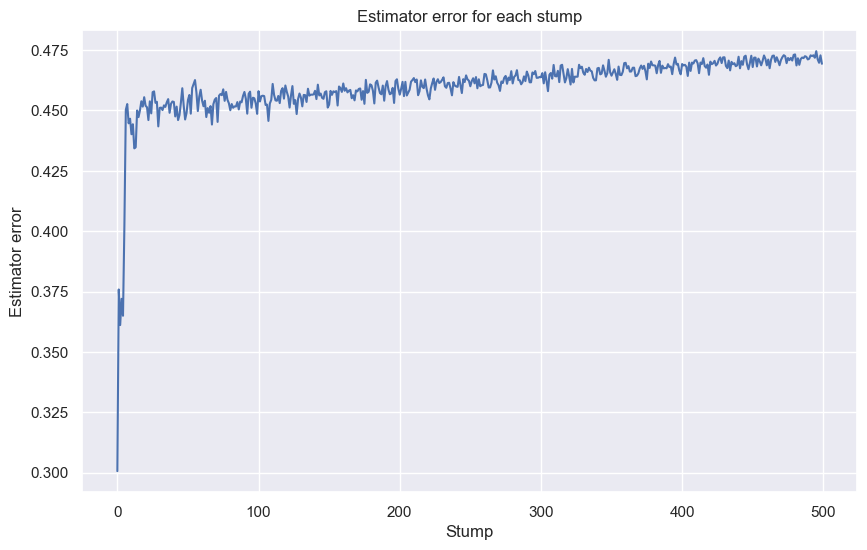

In [49]:
from typing import Dict

def plot_values_per_stump(
    data_dict: Dict[str, List[float]], 
    save: bool = False, 
    combined: bool = True
) -> None:
    sns.set(style="darkgrid", rc={"figure.figsize": (10, 6)})
    
    if combined:
        plt.figure(figsize=(12, 6))
        for value_name, data in data_dict.items():
            sns.lineplot(data=data, label=value_name)
        plt.title("Values per Stump")
        plt.xlabel("Stump")
        plt.ylabel("Value")
        plt.legend()
        if save:
            plt.savefig(plots_path / f"estimator_combined_plot_{MAXIMUM_STUMPS}.png")
        plt.show()
    
    for value_name, data in data_dict.items():
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=data)
        plt.title(f"{value_name} for each stump")
        plt.xlabel("Stump")
        plt.ylabel(value_name)
        if save:
            compacted = ''.join(value_name.split(' '))
            plt.savefig(plots_path / f"{compacted}_{MAXIMUM_STUMPS}.png")
        plt.show()


X, y = get_x_y_from_df(dataset_df)

classifier = AdaBoost(n_estimators=MAXIMUM_STUMPS)
classifier.fit(X, y)

alphas_per_stump = classifier.alphas.tolist()
error_per_stump = classifier.estimator_errors.tolist()

data_dict = {
    "Estimator weight": alphas_per_stump,
    "Estimator error": error_per_stump
}

plot_values_per_stump(data_dict, save=True, combined=True)

# Implementação do AdaBoost com Sklearn

Sklearn AdaBoost:   0%|          | 0/500 [00:00<?, ?it/s]

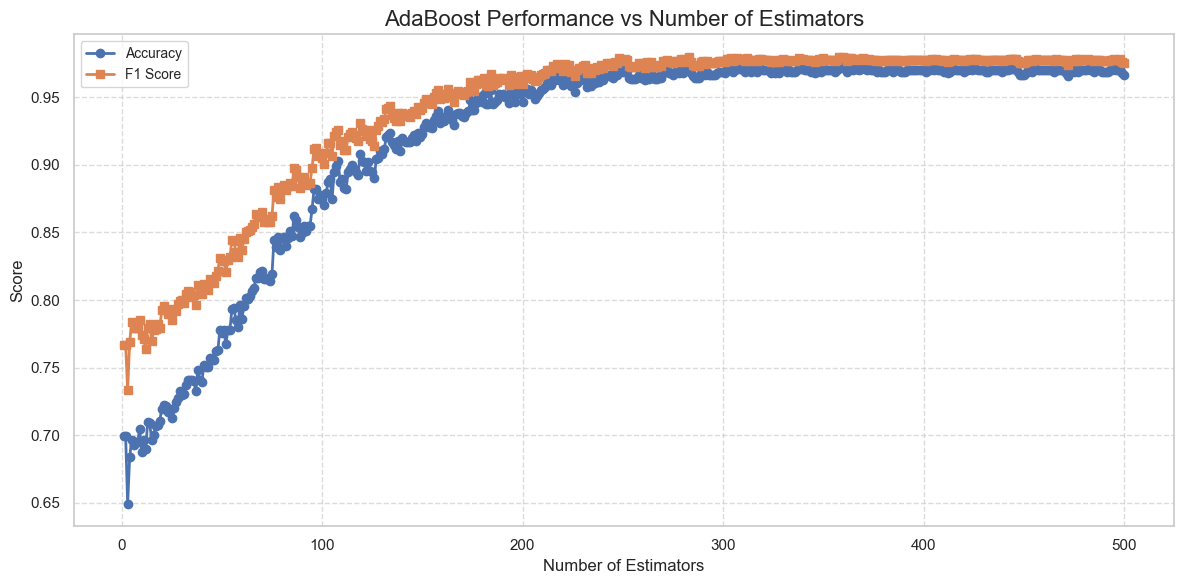

Best Accuracy: 0.9728 with 283 estimators
Best F1 Score: 0.9799 with 283 estimators


In [50]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

def evaluate_adaboost(X, y, n_estimators_range, cv=K_FOLDS_COUNT):
    
    encoder = OneHotEncoder(handle_unknown="ignore", dtype=np.int8)
    encoder_df = pd.DataFrame(encoder.fit_transform(X).toarray())
    encoder_df.columns = encoder.get_feature_names_out()

    X = encoder_df

    accuracy_scores = []
    f1_scores = []
    
    for n_estimators in tqdm(n_estimators_range, desc="Sklearn AdaBoost", total=len(n_estimators_range)):
        clf = AdaBoostClassifier(n_estimators=n_estimators, algorithm="SAMME", random_state=RANDOM_SEED)
        
        accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy').mean()
        f1 = cross_val_score(clf, X, y, cv=cv, scoring='f1').mean()
        
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
    
    return accuracy_scores, f1_scores

def plot_adaboost_performance(n_estimators_range, accuracy_scores, f1_scores, save_path=None):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    plt.plot(n_estimators_range, accuracy_scores, marker='o', label='Accuracy', linewidth=2)
    plt.plot(n_estimators_range, f1_scores, marker='s', label='F1 Score', linewidth=2)

    plt.title("AdaBoost Performance vs Number of Estimators", fontsize=16)
    plt.xlabel("Number of Estimators", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    best_accuracy = max(accuracy_scores)
    best_accuracy_n = n_estimators_range[accuracy_scores.index(best_accuracy)]
    best_f1 = max(f1_scores)
    best_f1_n = n_estimators_range[f1_scores.index(best_f1)]

    print(f"Best Accuracy: {best_accuracy:.4f} with {best_accuracy_n} estimators")
    print(f"Best F1 Score: {best_f1:.4f} with {best_f1_n} estimators")

X, y = get_x_y_from_df(dataset_df)

n_estimators_range = range(1, MAXIMUM_STUMPS + 1)
accuracy_scores_bench, f1_scores_bench = evaluate_adaboost(X, y, n_estimators_range)

plot_adaboost_performance(n_estimators_range, accuracy_scores_bench, f1_scores_bench,
                          save_path=plots_path / f"benchmark_adaboost_performance_{MAXIMUM_STUMPS}.png")



# Comparação entre implementações: customizada e benchmark (sklearn)

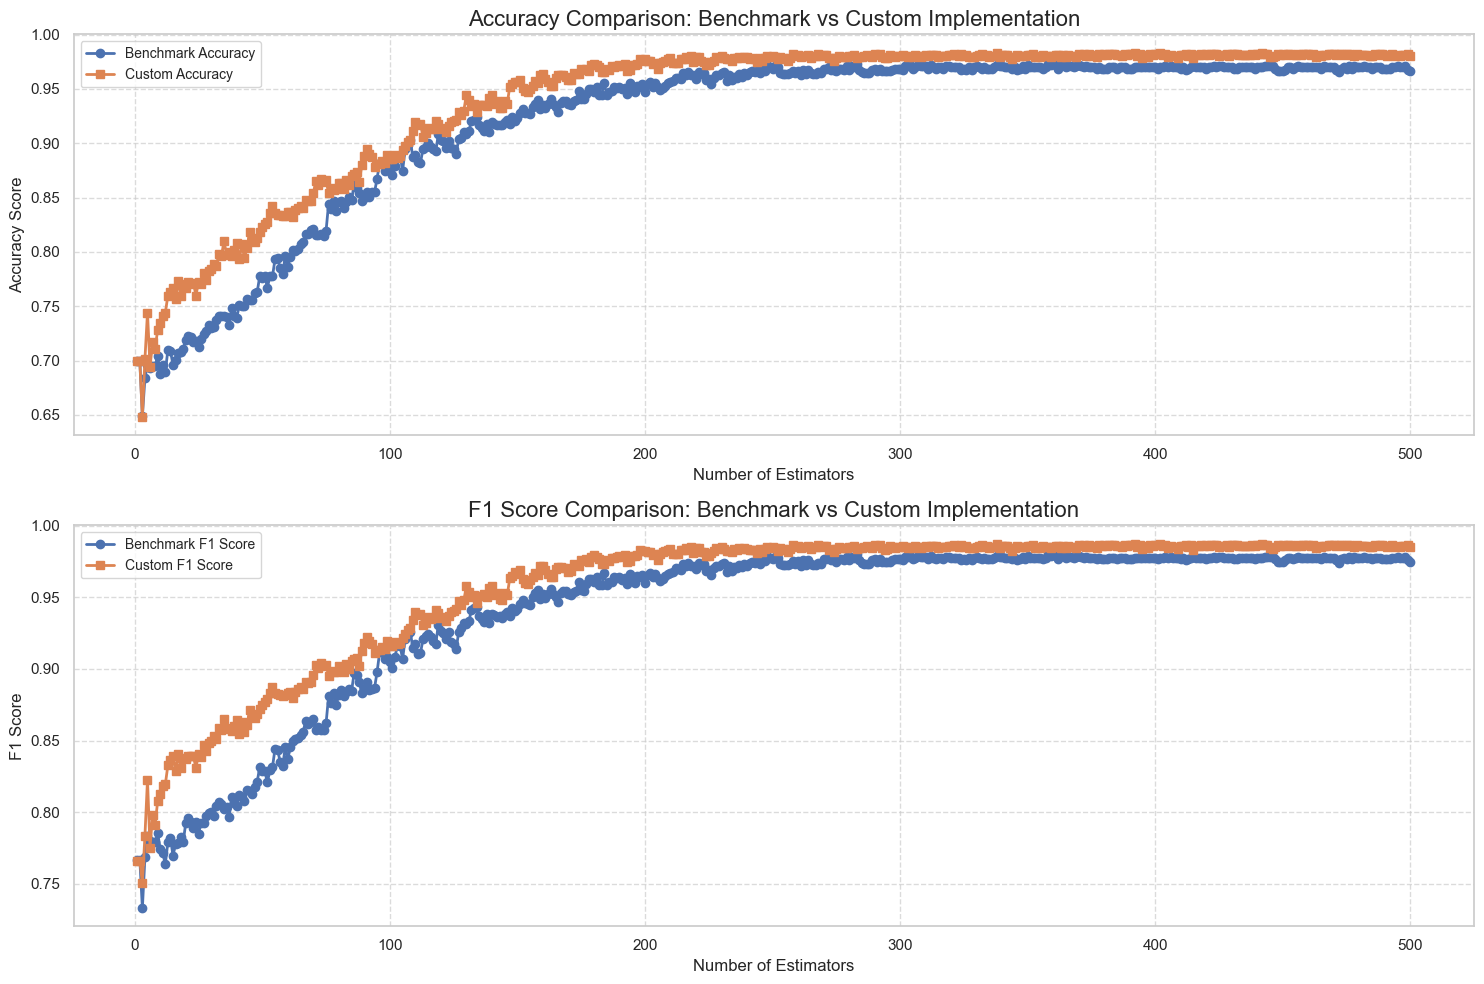

Best Benchmark Accuracy: 0.9728
Best Custom Accuracy: 0.9833
Accuracy Difference: -0.0105
Best Benchmark F1 Score: 0.9799
Best Custom F1 Score: 0.9874
F1 Score Difference: -0.0075


In [51]:
def compare_adaboost_implementations(
    n_estimators_range: range,
    benchmark_metrics: Tuple[List[float], List[float]],
    custom_metrics: Tuple[List[float], List[float]],
    save_path: str = None
) -> None:
    accuracy_scores_bench, f1_scores_bench = benchmark_metrics
    accuracy_scores_custom, f1_scores_custom = custom_metrics

    plt.figure(figsize=(15, 10))
    sns.set_style("whitegrid")

    plt.subplot(2, 1, 1)
    plt.plot(n_estimators_range, accuracy_scores_bench, marker='o', label='Benchmark Accuracy', linewidth=2)
    plt.plot(n_estimators_range, accuracy_scores_custom, marker='s', label='Custom Accuracy', linewidth=2)
    plt.title("Accuracy Comparison: Benchmark vs Custom Implementation", fontsize=16)
    plt.xlabel("Number of Estimators", fontsize=12)
    plt.ylabel("Accuracy Score", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.plot(n_estimators_range, f1_scores_bench, marker='o', label='Benchmark F1 Score', linewidth=2)
    plt.plot(n_estimators_range, f1_scores_custom, marker='s', label='Custom F1 Score', linewidth=2)
    plt.title("F1 Score Comparison: Benchmark vs Custom Implementation", fontsize=16)
    plt.xlabel("Number of Estimators", fontsize=12)
    plt.ylabel("F1 Score", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    best_accuracy_bench = max(accuracy_scores_bench)
    best_accuracy_custom = max(accuracy_scores_custom)
    best_f1_bench = max(f1_scores_bench)
    best_f1_custom = max(f1_scores_custom)

    print(f"Best Benchmark Accuracy: {best_accuracy_bench:.4f}")
    print(f"Best Custom Accuracy: {best_accuracy_custom:.4f}")
    print(f"Accuracy Difference: {best_accuracy_bench - best_accuracy_custom:.4f}")
    print(f"Best Benchmark F1 Score: {best_f1_bench:.4f}")
    print(f"Best Custom F1 Score: {best_f1_custom:.4f}")
    print(f"F1 Score Difference: {best_f1_bench - best_f1_custom:.4f}")

benchmark_metrics = (accuracy_scores_bench, f1_scores_bench)
custom_metrics = (accuracy_scores, f1_scores)

compare_adaboost_implementations(
    n_estimators_range,
    benchmark_metrics,
    custom_metrics,
    save_path=plots_path / f"adaboost_comparison_{MAXIMUM_STUMPS}.png"
)